# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
rs = 12345

In [2]:
df0 = pd.read_csv('/datasets/geo_data_0.csv', index_col = 'id')
df1 = pd.read_csv('/datasets/geo_data_1.csv', index_col = 'id')
df2 = pd.read_csv('/datasets/geo_data_2.csv', index_col = 'id')

In [3]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, txEyH to 1CWhH
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB


In [4]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, kBEdx to relB0
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB


In [5]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, fwXo0 to V9kWn
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB


**Данные по сути уже подготовлены. Все значения в подходящих типах и не имеют пропусков. Все, что потребовалось - засунуть id в индексы, для последующего обучения**

## Обучение и проверка модели

In [6]:
def mrsemean(df):
    target = df['product']
    features = df.drop('product', axis = 1)
    features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=rs)
    model = LinearRegression()
    model.fit(features_train, target_train)
    predict = model.predict(features_valid)
    return mean_squared_error(target_valid, predict, squared=False), predict.mean(), predict, target_valid
    

In [7]:
mrse0, meanpred0, predict0, target0 = mrsemean(df0)
mrse1, meanpred1, predict1, target1 = mrsemean(df1)
mrse2, meanpred2, predict2, target2 = mrsemean(df2)
predtarg0 = pd.DataFrame({'predict':predict0, 'target' : target0})
predtarg1 = pd.DataFrame({'predict':predict1, 'target' : target1})
predtarg2 = pd.DataFrame({'predict':predict2, 'target' : target2})

In [8]:
tab = pd.DataFrame({'Регион 1': [mrse0, meanpred0, df0['product'].mean()],
                    'Регион 2': [mrse1, meanpred1, df1['product'].mean()],
                    'Регион 3': [mrse2, meanpred2, df2['product'].mean()]})
tab.index = ['MRSE', 'предсказания(сред. знач.)', 'реальные сред. знач.']


In [9]:
print('Значения в тыс. барр.')
tab

Значения в тыс. барр.


,Регион 1,Регион 2,Регион 3
MRSE,37.579422,0.893099,40.029709
предсказания(сред. знач.),92.592568,68.728547,94.965046
реальные сред. знач.,92.500000,68.825000,95.000000


**При тестировании моделей на валидационной выборке мы получили достаточно высокий МРСЕ в регионах 1 и 3. Реальные средние значения объемов добычи и предсказанные практически не отличаются во всех регионах.**

## Подготовка к расчёту прибыли

**Рассчитаем минимальный объем добычи для одной скважины и для 200**

In [10]:
minvol1 = 1e10/(450*1e3*200) # - Безубыточный объем для 1 скважины
minvol200 = 1e10/(450*1e3) # - Безубыточный объем для 200 скважин

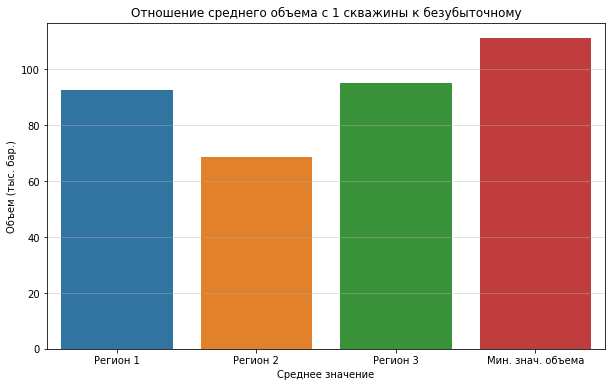

In [11]:
a = pd.DataFrame({0 : minvol1}, index = ['Мин. знач. объема'])
b = tab.loc['предсказания(сред. знач.)',:]
c =  pd.concat([b, a])
plt.figure(figsize=(10, 6))
sns.barplot(data = c , x = c.index, y = 0)
plt.ylabel('Объем (тыс. бар.)')
plt.xlabel('Среднее значение')
plt.grid(axis = 'y', alpha = 0.5)
plt.title('Отношение среднего объема с 1 скважины к безубыточному')
plt.show()

**Предсказанные средния значения объема ниже безубыточного**

**Просчитаем прибыль по топ 200 предсказанным скважинам по их реальным значениям**

In [12]:
price_per_1_unit = 45e4 # Цена за 1.000 баррелей нефти 
price_per_reg = 1e10 # Стоимость разработки региона

In [13]:
def profit(predtarg):
    return predtarg.sort_values('predict', ascending = False)[0:200]['target'].sum()*price_per_1_unit - price_per_reg 

In [14]:
profittab = pd.DataFrame({"Прибыль":[profit(predtarg0), profit(predtarg1), profit(predtarg2)]},
                         index = ['1 Регион','2 Регион','3 Регион'])
profittab

,Прибыль
1 Регион,3.320826e+09
2 Регион,2.415087e+09
3 Регион,2.710350e+09


**По таблице не очень понятно, построим график**

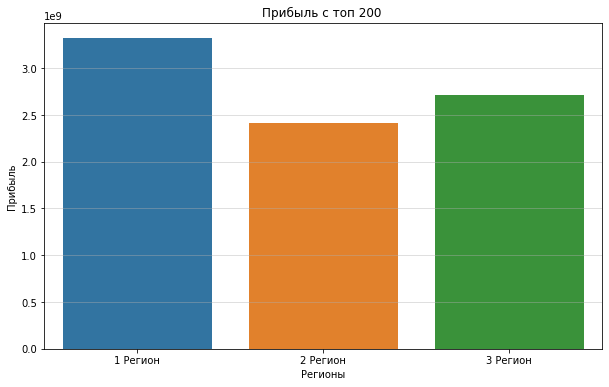

In [15]:
plt.figure(figsize=(10, 6))
sns.barplot(data =  profittab, y = 'Прибыль', x = profittab.index)
plt.xlabel('Регионы')
plt.grid(axis = 'y', alpha = 0.5)
plt.ylabel('Прибыль')
plt.title('Прибыль с топ 200 ')
plt.show()

**Так же посмотрим выбросы по предсказанным и реальным значениям**

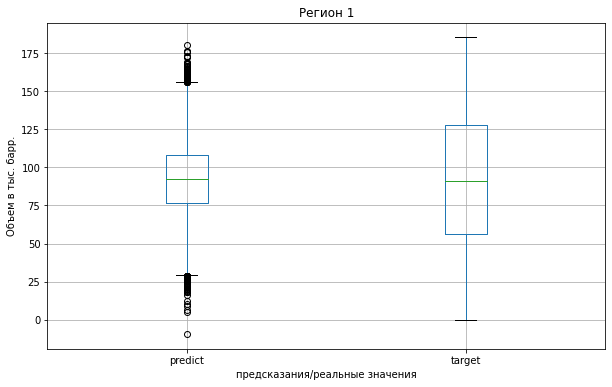

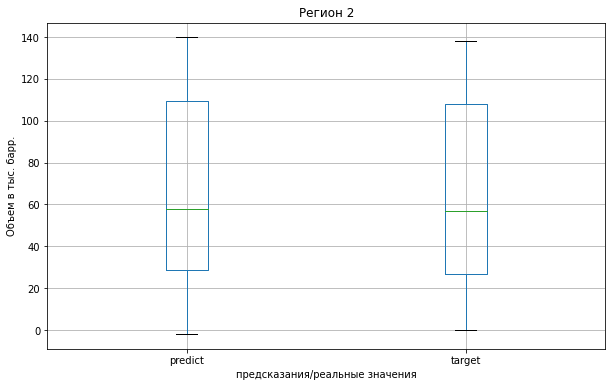

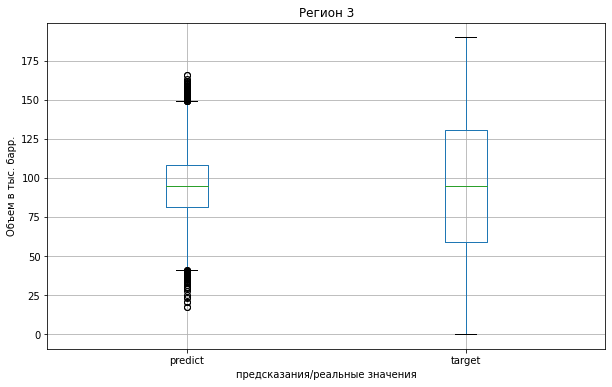

In [16]:
for ind,data in enumerate([predtarg0, predtarg1, predtarg2], start=1):
    plt.figure(figsize=(10, 6))
    data.boxplot()
    plt.ylabel("Объем в тыс. барр.")
    plt.title(f'Регион {ind}')
    plt.xlabel("предсказания/реальные значения")

## Расчёт прибыли и рисков 

**Пременим bootstrap**

In [17]:
import numpy as np
state = np.random.RandomState(rs)
def bootstrap(predtarg):
    result = []
    for i in range(1000):
        subsample = predtarg.sample(n=500, replace=True, random_state = state)
        result.append(profit(subsample))
    result = pd.Series(result)
    mean = result.mean()
    upper  = result.quantile(0.975)
    lower = result.quantile(0.025)
    probability = result.loc[result < 0].count() / result.count() * 100
    return mean, upper, lower, probability

In [18]:
mean0, upper0, lower0, probability0 = bootstrap(predtarg0)
mean1, upper1, lower1, probability1 = bootstrap(predtarg1)
mean2, upper2, lower2, probability2 = bootstrap(predtarg2)

In [19]:
boottab =  pd.DataFrame({"Средняя прибыль ₽":[mean0, mean1, mean2,], 'Верхнее значение довер. интервала ₽':[upper0, upper1, upper2,],
                         'Нижнее значение довер. интервала ₽':[lower0, lower1, lower2],
                         'Вероятность убытков %':[probability0, probability1, probability2,]},
                        index = ['1 Регион','2 Регион','3 Регион'])

In [20]:
boottab

,Средняя прибыль ₽,Верхнее значение довер. интервала ₽,Нижнее значение довер. интервала ₽,Вероятность убытков %
1 Регион,3.961650e+08,9.097669e+08,-1.112155e+08,6.9
2 Регион,4.611558e+08,8.629521e+08,7.805081e+07,0.7
3 Регион,3.929505e+08,9.345629e+08,-1.122276e+08,6.5


**Вероятность убытков ниже 2.5% только во втором регионе, следовательно по условиям подходит только он. Так же в этом регионе выше средняя прибыль с 200 лучших из случайных 500. Могу добавить, что в регионах 1 и 3 больше разброс по добыче: именно во втором регионе меньше шансов найти "золотую" скважину, но и шансов попасть в пустую - тоже.**